In [1]:
from matplotlib.pyplot import subplot_mosaic
import numpy
from lsst.afw.image import Image
from lsst.geom import Box2I, Point2I, Extent2I
import throughput
from throughput import footprint_signal_spans
from lsst.daf.butler import Butler

import lsst.afw.detection as afwDetect
import lsst.ip.isr as isr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.patches as patches

import gc


In [2]:
import importlib
importlib.reload(throughput)

<module 'throughput' from '/home/d/duncanw/repos/throughput/throughput.py'>

In [3]:
def makeDummyFullFocalPlane():   
    ### Jim provided this part (edited by Duncan)
    """
        Builds a mock image of a CCOB spot overlaid on a real bias image after overscan correction.
    """
    repo = '/repo/main'
    collections = ['LSSTCam/raw/all']
    butler = Butler(repo, collections=collections)
    refs = list(set(butler.registry.queryDatasets(datasetType='raw', instrument='LSSTCam',where="exposure.obs_id='MC_C_20201008_000019'", detector=94))) # some random bias exposure
    exp = butler.get(refs[0])
    exp = throughput.isr_ccob_exposure(exp)
    img = exp.getImage()
    
    x=numpy.arange(0,img.array.shape[1])
    y=numpy.arange(0,img.array.shape[0])
    xc, yc = 2000, 1500
    sx, sy = 50, 50
    xx,yy=numpy.meshgrid(x,y)    
    img.array += 10000*numpy.exp( -( xx-xc )**2/(2*sx**2) -( yy-yc )**2/(2*sy**2) )
    return exp

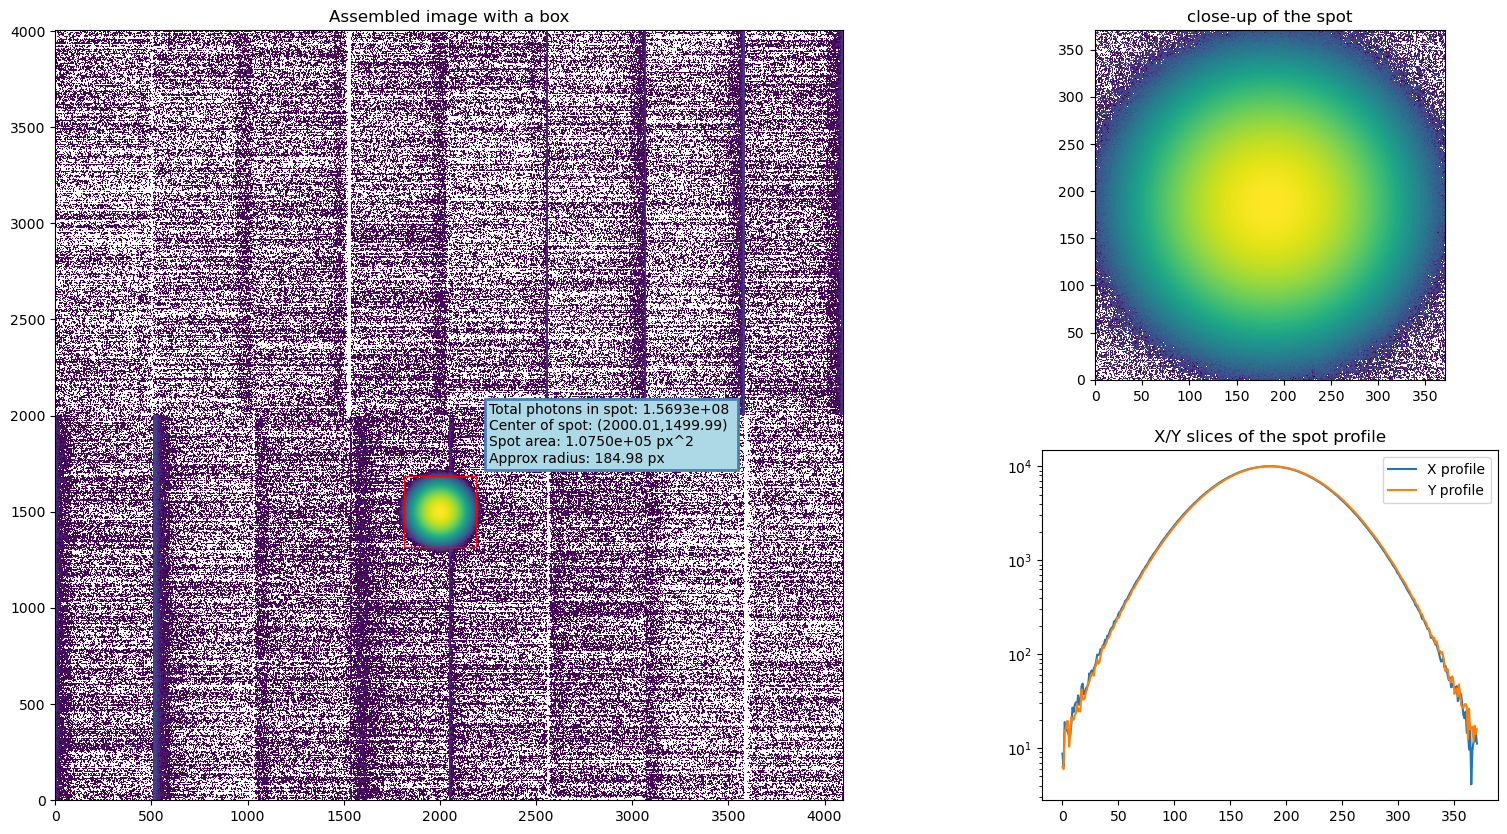

In [4]:
from matplotlib.colors import LogNorm

exp=makeDummyFullFocalPlane()
spot_info = throughput.get_spots_counts(exp, force_circle=True) # detects spots in exp. Returns a total signal, center of mass, and footprint for each detected spot
if len(spot_info) == 0: 
    print("No spot found")
else:
    counts, center, footprint = spot_info[0]
    bbox=footprint.getBBox()
    spot_area = footprint.getArea()
    approx_radius = np.sqrt(spot_area/np.pi)

    fig, axs = subplot_mosaic(
        """
        AAB
        AAC
        """,
        figsize=(20,10)
    )

    axs["A"].imshow(exp.getImage().array,norm=LogNorm(vmin=1, vmax=1e4),origin="lower")
    rect = patches.Rectangle((bbox.getMinX(), bbox.getMinY()), bbox.getWidth(), bbox.getHeight(), linewidth=1, edgecolor='r', facecolor='none')
    axs["A"].add_patch(rect)
    text = f'Total photons in spot: {counts:.4e} \nCenter of spot: ({center[0]:.2f},{center[1]:.2f}) \nSpot area: {spot_area:.4e} px^2 \nApprox radius: {approx_radius:.2f} px'
    axs["A"].annotate(text,
                    xy=(bbox.getMaxX(), bbox.getMaxY()), xycoords='data',
                    xytext=(10, 10), textcoords='offset points',bbox=dict(boxstyle="square,pad=0.3",
                          fc="lightblue", ec="steelblue", lw=2))
    axs["A"].set_title("Assembled image with a box")
    axs["B"].set_title("close-up of the spot")
    axs["B"].imshow(exp.getImage()[bbox].array,norm=LogNorm(vmin=1, vmax=1e4),origin="lower")
    axs["C"].set_title("X/Y slices of the spot profile")
    axs["C"].plot(exp.getImage()[bbox].array[bbox.getWidth()//2], label="X profile")
    axs["C"].plot(exp.getImage()[bbox].array[:,bbox.getHeight()//2], label="Y profile")
    axs["C"].legend()
    axs["C"].set_yscale("log")
    plt.show()